In [7]:
from google.colab import drive
drive.flush_and_unmount()
drive.mount('/content/gdrive')
try:
  os.chdir('gdrive/MyDrive/')
except:
  pass

Mounted at /content/gdrive


In [6]:
!pip install pmdarima
!pip install ruptures

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
import os
import itertools
import warnings
from datetime import datetime as dt

import numpy as np
import pandas as pd
import scipy.stats as stats
import seaborn as sns
import statsmodels.api as sm
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

from astropy.timeseries import LombScargle
from ipywidgets import interact, interactive, fixed, interact_manual, interactive_output
from pmdarima.arima import auto_arima
from ruptures import Pelt
from scipy.signal import welch
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller, acf, pacf, kpss

import ipywidgets as widgets
import ruptures as rpt

%matplotlib inline

warnings.filterwarnings("ignore")

In [8]:
# from google.colab import drive
# drive.mount('/content/gdrive')



# 1. Data Reading

In [4]:
filename = "Test_data.csv"
raw_df = pd.read_csv(filename, header=None)
raw_df.columns = ['datetime', 'ts1', 'ts2']
raw_df['datetime'] = pd.to_datetime(raw_df['datetime']-719529,unit='d').round('s')
raw_df.set_index('datetime', inplace = True)

# date = df['datetime']

raw_df.head(10)


,ts1,ts2
datetime,,
2008-01-01 00:00:45,NaN,NaN
2008-01-01 00:02:45,NaN,0.87505
2008-01-01 00:04:45,NaN,NaN
2008-01-01 00:06:45,NaN,NaN
2008-01-01 00:08:45,NaN,NaN
2008-01-01 00:10:45,NaN,NaN
2008-01-01 00:12:45,NaN,NaN
2008-01-01 00:14:45,NaN,NaN
2008-01-01 00:16:45,NaN,NaN


In [5]:
# Frequency and corr variables
# A dictionary mapping human-readable frequency strings to Pandas frequency codes
frequency = {'1 minute': 'T', '5 minutes': '5T', '10 minutes': '10T', '30 minutes': '30T', 
             '1 hour': 'H', '2 hours': '2H', '3 hours': '3H', '5 hours': '5H', '12 hours': '12H',
             '1 day': 'D', '2 days': '2D', '3 days': '3D', '5 days': '5D', '7 days': '7D', '30 days': '30D'}

# A list of human-readable frequency strings
freq_types = ['1 minute', '5 minutes', '10 minutes', '30 minutes', '1 hour', '2 hours', '3 hours', '5 hours', '12 hours', '1 day', '2 days', '3 days', '5 days', '7 days', '30 days']

# A dictionary mapping human-readable frequency strings to the number of minutes in that frequency
frequency_int = {'1 minute': 4, '5 minutes': 20, '10 minutes': 40, '30 minutes': 120, 
             '1 hour': 240, '2 hours': 480, '3 hours': 720, '5 hours': 1200, '12 hours': 2880,
             '1 day': 5760, '2 days': 11520, '3 days': 17280, '5 days': 28800, '7 days': 40320, '30 days': 172800}

# A dictionary to store positive correlations between all possible pairs of columns in raw_df
pos_corr = {}

# Iterate over all possible pairs of columns in raw_df and create the corresponding correlation keys in pos_corr
for pair in itertools.product(raw_df.columns, repeat=2):
    ch1, ch2 = pair
    if f'corr({ch2}&{ch1})' in pos_corr:
        pos_corr[f'corr({ch1}&{ch2})'] = f'corr({ch2}&{ch1})'  # Use the existing key if it exists in reverse order
    else:
        pos_corr[f'corr({ch1}&{ch2})'] = f'corr({ch1}&{ch2})'  # Otherwise create the key in the original order

# Extract a set of unique correlation column keys from pos_corr and remove the diagonal correlation keys (corr(col&col))
corr_cols = set(pos_corr.values())
for col in raw_df.columns:
    corr_cols.discard(f'corr({col}&{col})')
corr_cols = list(corr_cols)  # Convert the set back to a list

# 2. Data preparation and cleaning

Data statistics

In [6]:
def data_stat(raw_df):
    desc = raw_df.describe(include = 'all')
    desc.loc['type'] = raw_df.dtypes
    desc.loc['median'] = raw_df.median()*10000//100/100
    desc.loc['mean'] = raw_df.mean()*10000//100/100
    desc.loc['mode'] = raw_df.mode().iloc[0]
    desc.loc['missing'] = (100. * raw_df.isna().sum() /len(raw_df)).round(2).astype(str) + '%'
    desc.loc['unique'] = raw_df.nunique()
    desc.loc['min'] = raw_df.min()
    desc.loc['max'] = raw_df.max()

    cols = ['type', 'count', 'missing', 'unique', 'min', '25%', '50%', '75%', 'max', 'mean', 'median', 'std', 'mode']
    desc = desc.loc[cols].round(2)
    return desc


# data_table.DataTable(data_stat(raw_df), 
#                      include_index=True, 
#                      num_rows_per_page=13,
#                      max_columns = len(raw_df.columns))
data_stat(raw_df)

,ts1,ts2
type,float64,float64
count,201517.0,936488.0
missing,84.68%,28.81%
unique,3901,10114
min,91.512942,0.60115
25%,95.106221,0.87145
50%,95.462056,0.945
75%,96.042938,1.0278
max,96.852863,1.10805
mean,95.17,0.92


Line plot

In [7]:
# Plot data
def missing_range(series):
    # Identify the start and end indices of consecutive missing values in the series
    mask = series.isna()
    changes = mask.ne(mask.shift()).cumsum()
    ranges = mask.groupby(changes).apply(lambda x: (x.index[0], x.index[-1]))
    return ranges

def plot_time_series(ts1, ts2, ts1_label='ts1', ts2_label='ts2',
                     ts3=None, ts3_label=None, ts4=None, ts4_label=None, figsize=(12, 10)):
    # Create subplots
    fig, axs = plt.subplots(nrows=2, ncols=1, figsize=figsize)

    # Plot first time series on first subplot
    axs[0].plot(ts1)
    axs[0].set_xlabel('Date')
    axs[0].set_ylabel('Price')
    axs[0].set_title(ts1_label)

    # Plot second time series on second subplot
    axs[1].plot(ts2)
    axs[1].set_xlabel('Date')
    axs[1].set_ylabel('Price')
    axs[1].set_title(ts2_label)

    # Plot third time series on both subplots if it is provided
    if ts3 is not None:
        axs[0].scatter(ts3, c='red')
        if ts3_label is not None:
            axs[0].legend([ts1_label, ts3_label])
        else:
            axs[0].legend([ts1_label, 'ts3'])

    if ts4 is not None:
        axs[1].scatter(ts4, c='red')
        if ts4_label is not None:
            axs[1].legend([ts2_label, ts4_label])
        else:
            axs[1].legend([ts2_label, 'ts4'])

    # Plot vertical lines for missing data ranges in ts3 and ts4
    for ts, ax in zip([ts3, ts4], axs):
        if ts is not None:
            for missing in missing_range(ts):
                ax.axvspan(missing[0], missing[1], color='gray', alpha=0.3)

    plt.show()

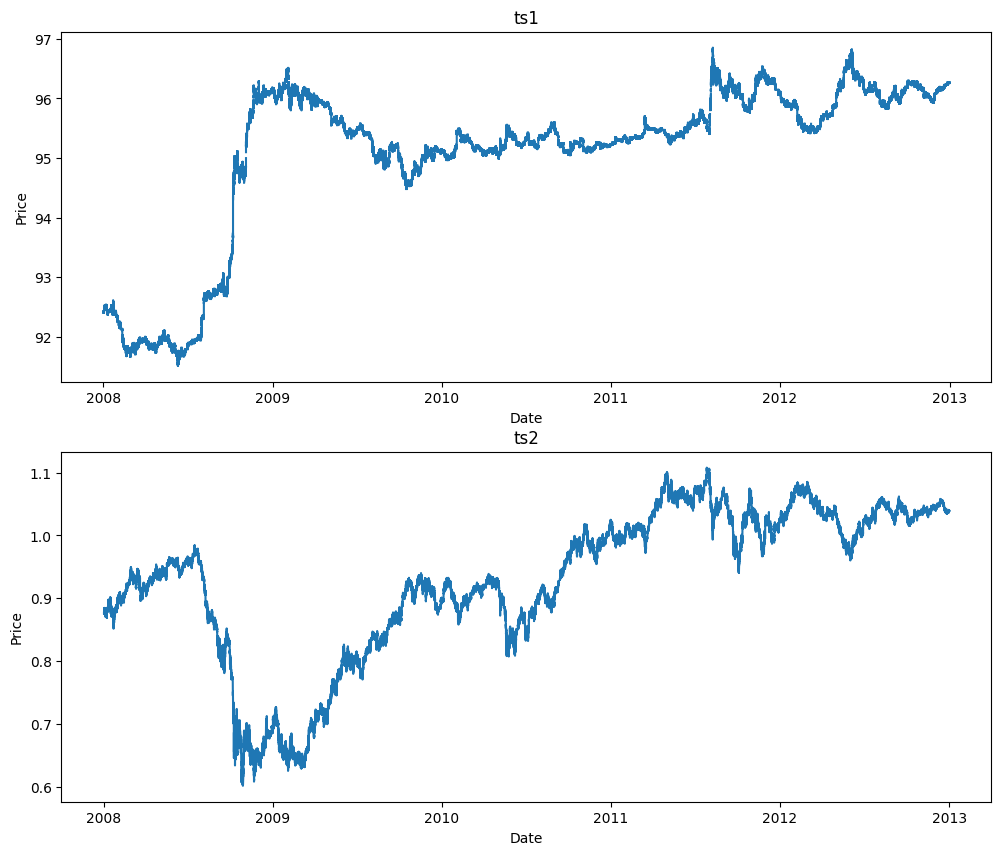

In [9]:
ts1 = raw_df['ts1']
ts2 = raw_df['ts2']
plot_time_series(ts1, ts2)

Missing data

In [11]:
resampled_df = raw_df.resample('15S').last().copy()
resampled_df.head()

,ts1,ts2
datetime,,
2008-01-01 00:00:45,NaN,NaN
2008-01-01 00:01:00,NaN,NaN
2008-01-01 00:01:15,NaN,NaN
2008-01-01 00:01:30,NaN,NaN
2008-01-01 00:01:45,NaN,NaN


In [12]:
# plt.figure(figsize=(40, 7))
# plt.grid()
# plt.margins(x=0)

# for i, col in enumerate(resampled_df.columns):
#     mis_len = len(resampled_df[resampled_df[col].isnull()].index)
#     plt.plot(resampled_df[resampled_df[col].isnull()].index, np.ones(mis_len)*i, '--o', label=f"{col}-missing:{mis_len}")
# plt.legend()
# plt.title('Price Missing Data')
# plt.yticks([])
# plt.yticks(range(len(resampled_df.columns)), resampled_df.columns);

Count missing values

In [13]:
# Function to count missing values in a series
def count_missing_values(series):
    return series.isna().sum()

# Function to find the maximum length of continuous missing values in a series
def max_missing_range(series):
    mask = series.isna()
    changes = mask.ne(mask.shift()).cumsum()
    counts = mask.groupby(changes).sum()
    return counts.max()

# Function to impute missing values in a series using a moving mean
def impute_missing_values(series, window):
    if series.isnull().any():
        rolling_mean = series.rolling(window=window, min_periods=1).mean()
        return series.fillna(rolling_mean)
    else:
        return series

# Function to convert intervals to days
def intervals_to_days(intervals):
    minutes = intervals * 2
    hours = minutes / 60
    days = hours / 24
    return days

# Count missing values in ts1 and ts2
missing_ts1 = count_missing_values(ts1)
missing_ts2 = count_missing_values(ts2)
print(f"Missing values in ts1: {missing_ts1}")
print(f"Missing values in ts2: {missing_ts2}")

# Get the maximum missing range in ts1 and ts2
max_ts1 = max_missing_range(ts1)
max_ts2 = max_missing_range(ts2)
print(f"Max missing range in ts1: {max_ts1}")
print(f"Max missing range in ts2: {max_ts2}")

# Convert the maximum missing ranges to days
days_ts1 = intervals_to_days(max_ts1)
days_ts2 = intervals_to_days(max_ts2)
print(f"Max missing range in ts1: {days_ts1:.2f} days")
print(f"Max missing range in ts2: {days_ts2:.2f} days")

Missing values in ts1: 1113924
Missing values in ts2: 378953
Max missing range in ts1: 3579
Max missing range in ts2: 2139
Max missing range in ts1: 4.97 days
Max missing range in ts2: 2.97 days


So min window size for any imputation/smoothing should be 5 days and 3 days respectively for ts1 and 2

Missing values in imputed ts1: 0
Missing values in imputed ts2: 0
Max missing range in imputed ts1: 0
Max missing range in imputed ts2: 0


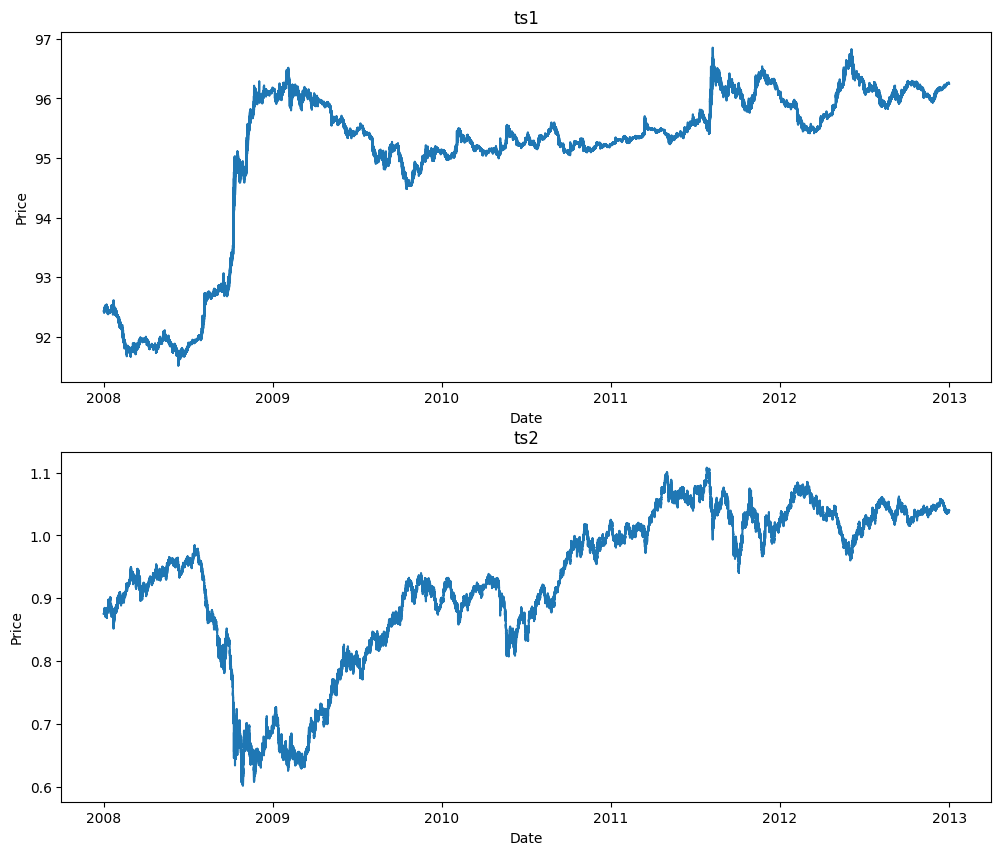

In [15]:
# Function to impute missing values in a series using a moving mean
def impute_missing_values(series, window):
    if series.isnull().any():
        rolling_mean = series.rolling(window=window, min_periods=1).mean()
        imputed_series = series.fillna(rolling_mean)
        imputed_series.fillna(method='bfill', inplace=True)  # Backfill since missing starting data
    else:
        imputed_series = series
    return imputed_series

# Impute missing values in ts1 and ts2 using their respective maximum missing ranges
imputed_ts1 = impute_missing_values(ts1, max_ts1)
imputed_ts2 = impute_missing_values(ts2, max_ts2)

# Print the number of missing values in the imputed series
print(f"Missing values in imputed ts1: {imputed_ts1.isna().sum()}")
print(f"Missing values in imputed ts2: {imputed_ts2.isna().sum()}")

# Calculate the maximum missing range in the imputed series
max_imputed_ts1 = max_missing_range(imputed_ts1)
max_imputed_ts2 = max_missing_range(imputed_ts2)

# Print the maximum missing range in the imputed series
print(f"Max missing range in imputed ts1: {max_imputed_ts1}")
print(f"Max missing range in imputed ts2: {max_imputed_ts2}")

# Plot the imputed time series
plot_time_series(imputed_ts1, imputed_ts2)

In [14]:
# find indexx of ana values from series
# take index of missing from imputed and plot together
# Replace non-missing values in ts1 with np.nan and modify fil_ts1
imputed_points1 = fil_ts1.fillna(ts1, inplace=True)
# Replace non-missing values in ts2 with np.nan and modify fil_ts2
imputed_points2 = fil_ts2.fillna(ts2, inplace=True)

# plot_time_series(ts1, ts2, date, ts1_label='ts1', ts2_label='ts2', 
#                      ts3=fil_ts1, ts3_label=None,ts4=fil_ts2, ts4_label=None, figsize=(12, 10))
# plt.plot(date,ts1)
# plt.scatter(date,f1)
# plt.show()

# 3. EDA
Perform exploratory statistical analysis on the data. Data is likely
distributed non parametrically so quartile tests for outliers will not be very effective. Results from EDA will hopefully inform how to deal with
outliers/noise missing values. High frequency data. 


In [17]:
clean_df=  pd.concat([imputed_ts1, imputed_ts2], axis=1)
clean_df.isna().sum()

ts1    0
ts2    0
dtype: int64

Test seasonality

In [20]:
def decompose(feature = None,model = None,freq = None,):

    figsize = (40, 12)
    fig, axs = plt.subplots(nrows=4, ncols=1, figsize=figsize)

    result = seasonal_decompose(clean_df[feature], model=model, period = frequency_int[freq])
    axs[0].plot(result.observed)
    axs[0].margins(x=0)
    axs[0].set_ylabel('Observed')
    axs[1].plot(result.trend)
    axs[1].set_ylabel('Trend')
    axs[1].margins(x=0)

    axs[2].plot(result.seasonal)
    axs[2].set_ylabel('Seasonal')
    axs[2].margins(x=0)

    axs[3].scatter(raw_df.index, result.resid, label=str(np.mean(abs(result.resid))))
    axs[3].set_ylabel('Residual')
    axs[3].margins(x=0)
    axs[3].legend()

feature = widgets.Dropdown(description='feature:', options=raw_df.columns, value = raw_df.columns[0])
model = widgets.Dropdown(description='model:', options=['additive', 'multiplicative'])
freq = widgets.Dropdown(description='Frequency:', options=['1 minute', '5 minutes', '10 minutes', '30 minutes', '1 hour', '2 hours', '3 hours','5 hours', '12 hours', '1 day', '2 days', '3 days', '5 days', '7 days', '30 days'], value='1 day')   

ui = widgets.HBox([feature, model, freq])

out = interactive_output(decompose, {'feature': feature,
                                     'model': model,
                                     'freq': freq,})
display(ui, out)

Output()

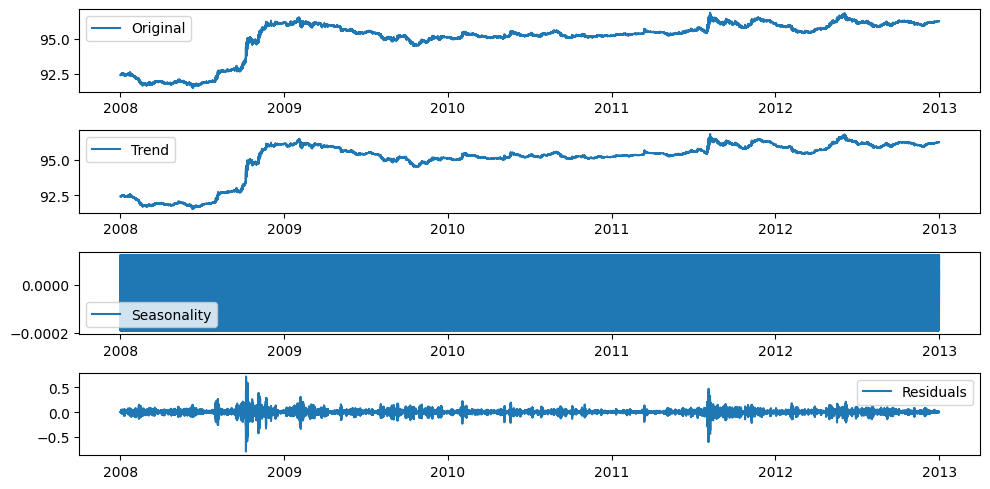

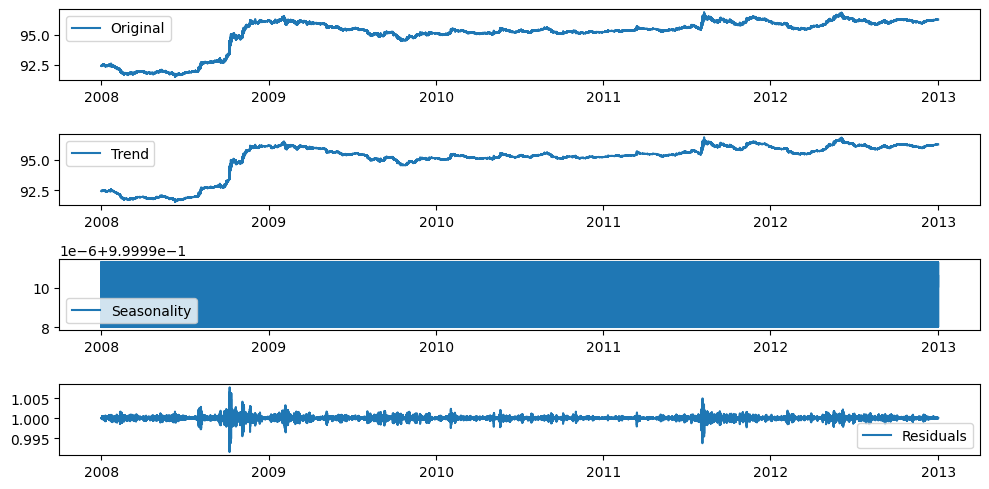

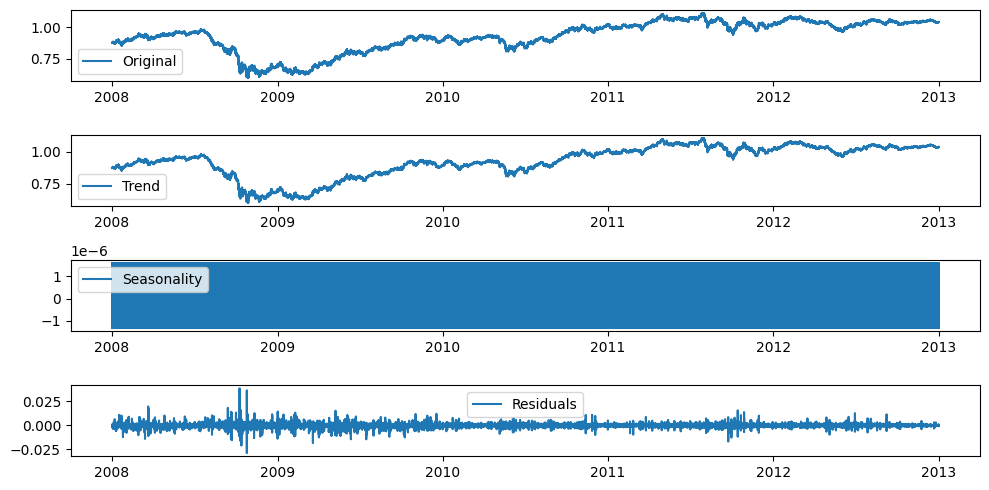

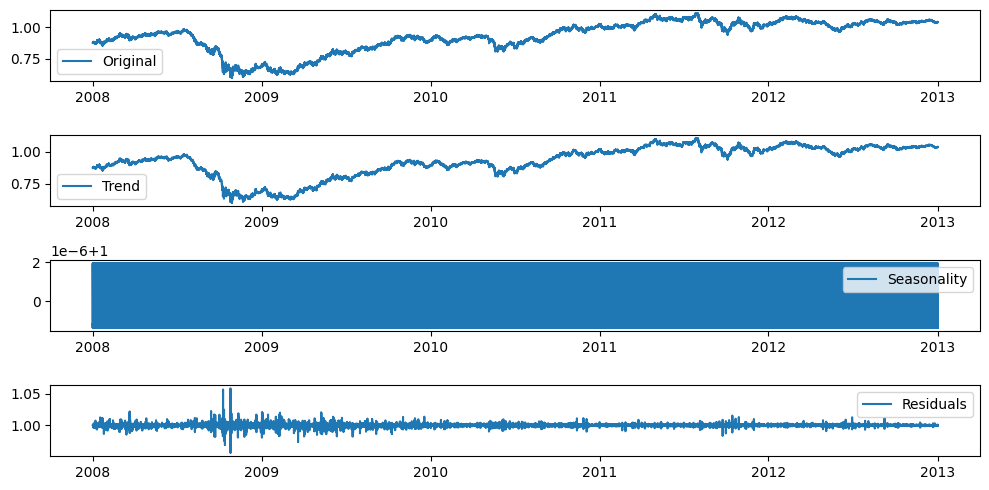

Correlation between Price and Trend: nan


TypeError: no numeric data to plot

In [23]:
# Determine seasonality using additive and multiplicative to compare
def plot_decomposition(timeseries, model, period):
    decomposition = sm.tsa.seasonal_decompose(timeseries, model=model, period=period)
    trend = decomposition.trend
    seasonal = decomposition.seasonal
    residual = decomposition.resid

    plt.figure(figsize=(10, 5))
    plt.subplot(411)
    plt.plot(timeseries, label='Original')
    plt.legend(loc='best')
    plt.subplot(412)
    plt.plot(trend, label='Trend')
    plt.legend()
    plt.subplot(413)
    plt.plot(seasonal, label='Seasonality')
    plt.legend()
    plt.subplot(414)
    plt.plot(residual, label='Residuals')
    plt.legend()
    plt.tight_layout()
    plt.show(block=False)

    return trend

def plot_seasonal_subseries(monthly_data):
    monthly_data.index = monthly_data.index.strftime('%B')
    groups = monthly_data.groupby(monthly_data.index)
    seasonal_data = pd.concat([pd.DataFrame({'Month': name, 'Price': group.values}) for name, group in groups], ignore_index=True)
    seasonal_data.pivot('Month', 'Price').plot(kind='bar', figsize=(12, 6), legend=False)
    plt.xlabel('Month')
    plt.ylabel('Price')
    plt.title('Seasonal Subseries Plot')
    plt.show()


period = 12

trend_additive = plot_decomposition(imputed_ts1, 'additive', period)
trend_multiplicative = plot_decomposition(imputed_ts1, 'multiplicative', period)
trend_additive = plot_decomposition(imputed_ts2, 'additive', period)
trend_multiplicative = plot_decomposition(imputed_ts2, 'multiplicative', period)

# Replace df with your actual DataFrame

corr = np.corrcoef(imputed_ts1, trend_additive)[0][1]
print('Correlation between Price and Trend:', corr)

monthly = imputed_ts1.resample('M').mean()
plot_seasonal_subseries(monthly)

corr = np.corrcoef(imputed_ts2, trend_additive)[0][1]
print('Correlation between Price and Trend:', corr)

monthly = imputed_ts2.resample('M').mean()
plot_seasonal_subseries(monthly)



In [24]:
# Detect Change Points or Structural Breaks


# Function to detect change points using the PELT algorithm
def detect_change_points(series, pen, min_size=100000):
    algo = rpt.Pelt(model="l2", min_size=min_size).fit(series.values)
    return algo.predict(pen=pen)

# Detect change points in the imputed time series
change_points = detect_change_points(imputed_ts1, pen=10)

# Plot the time series and detected change points
plt.plot(imputed_ts1.values)
for cp in change_points:
    plt.axvline(cp, color='r')
plt.title('Change Points Detected with PELT')
plt.show()

KeyboardInterrupt: 

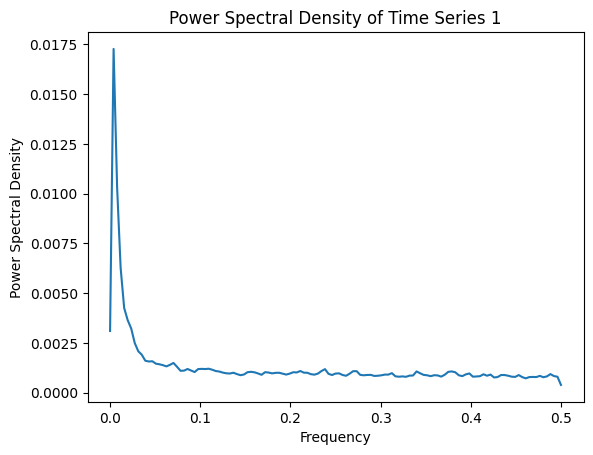

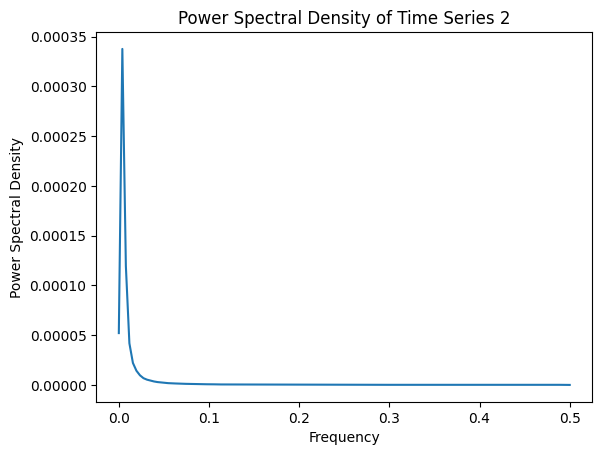

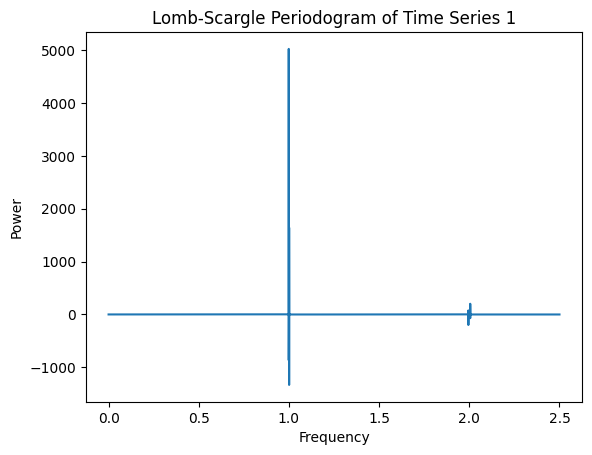

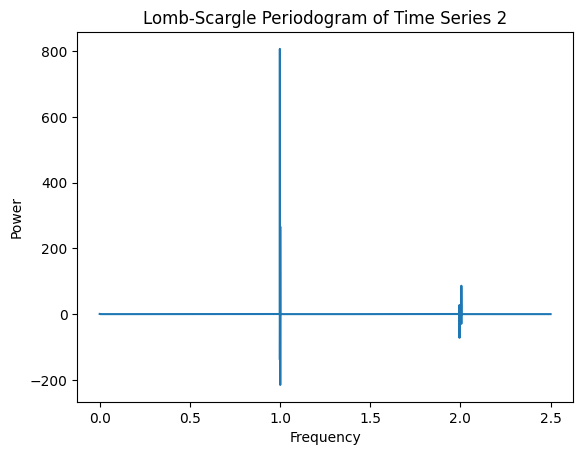

In [26]:
# Spectral Analysis

def plot_power_spectral_density(ts, title):
    freqs, psd = welch(ts)
    plt.plot(freqs, psd)
    plt.xlabel('Frequency')
    plt.ylabel('Power Spectral Density')
    plt.title(title)
    plt.show()

def plot_lomb_scargle_periodogram(ts, title):
    time = np.arange(len(ts))
    ls = LombScargle(time, ts)
    freq, power = ls.autopower()
    plt.plot(freq, power)
    plt.xlabel('Frequency')
    plt.ylabel('Power')
    plt.title(title)
    plt.show()


# Plot power spectral density
plot_power_spectral_density(imputed_ts1, 'Power Spectral Density of Time Series 1')
plot_power_spectral_density(imputed_ts2, 'Power Spectral Density of Time Series 2')

# Plot Lomb-Scargle periodogram
plot_lomb_scargle_periodogram(imputed_ts1, 'Lomb-Scargle Periodogram of Time Series 1')
plot_lomb_scargle_periodogram(imputed_ts2, 'Lomb-Scargle Periodogram of Time Series 2')

In [ ]:
# Hurst exponent
# from numba import jit

# @jit(nopython=True)
def hurst_exponent_fast(ts):
    lags = np.arange(2, 100)
    tau = np.array([np.sqrt(np.std(np.subtract(ts[lag:], ts[:-lag]))) for lag in lags])
    poly = np.polyfit(np.log(lags), np.log(tau), 1)
    return poly[0] * 2.0

print('Hurst Exponent (Fast):', hurst_exponent_fast(fil_ts1.values))
print('Hurst Exponent (Fast):', hurst_exponent_fast(fil_ts2.values))

In [ ]:
# Autocorellation
#     Cyclicity
#      White noise

from statsmodels.tsa.stattools import acf, pacf


def plot_acf_pacf(data, max_lags=None):
    fig, axes = plt.subplots(2, 1, figsize=(10,8))
    
    # Compute ACF and PACF
    acf_vals = acf(data, nlags=max_lags)
    pacf_vals = pacf(data, nlags=max_lags)
    
    # Plot ACF
    axes[0].stem(acf_vals, use_line_collection=True)
    axes[0].axhline(y=0, linestyle='--', color='gray')
    axes[0].set_ylabel('ACF')
    axes[0].set_xlim([-1, max_lags+1])
    axes[0].set_ylim([-1, 1])
    
    # Plot PACF
    axes[1].stem(pacf_vals, use_line_collection=True)
    axes[1].axhline(y=0, linestyle='--', color='gray')
    axes[1].set_xlabel('Lag')
    axes[1].set_ylabel('PACF')
    axes[1].set_xlim([-1, max_lags+1])
    axes[1].set_ylim([-1, 1])
    
    plt.show()

def autocorrelation_test(series, lags=40):
    """
    Perform an autocorrelation test on a Pandas Series.

    Parameters:
    -----------
    series : pandas.Series
        The input time series.
    lags : int, default=40
        The number of lags to consider for the autocorrelation test.

    Returns:
    --------
    dict
        A dictionary containing the results of the autocorrelation test.
    """
    acf, pvalue = sm.stats.acorr_ljungbox(series, lags=lags)
    result = {'acf': acf, 'pvalue': pvalue}
    return result


def cyclicity_test(series, period=24):
    """
    Perform a cyclicity test on a Pandas Series.


    """
    x = np.arange(0, len(series))
    sin = np.sin(2 * np.pi * x / period)
    cos = np.cos(2 * np.pi * x / period)
    X = np.column_stack((np.ones(len(x)), sin, cos))
    beta = np.linalg.lstsq(X, series, rcond=None)[0]
    fitted = beta[0] + beta[1] * sin + beta[2] * cos
    resids = series - fitted
    result = {'fitted': fitted, 'resids': resids}
    return result


def white_noise_test(series):
    """
    Perform a white noise test on a Pandas Series.

        A dictionary containing the results of the white noise test.
    """
    lbvalue, pvalue = sm.stats.diagnostic.acorr_ljungbox(series, lags=[1], boxpierce=True)
    result = {'lbvalue': lbvalue[0], 'pvalue': pvalue[0]}
    return result



# Apply functions to series1
plot_acf_pacf(imputed_ts1, max_lags=12)
acf_pvalue = autocorrelation_test(imputed_ts1)['pvalue']
cyclicity_fitted = cyclicity_test(imputed_ts1)['fitted']
white_noise_pvalue = white_noise_test(imputed_ts1)['pvalue']

# Apply functions to series2
plot_acf_pacf(imputed_ts2, max_lags=12)
acf_pvalue = autocorrelation_test(imputed_ts2)['pvalue']
cyclicity_fitted = cyclicity_test(imputed_ts2)['fitted']
white_noise_pvalue = white_noise_test(imputed_ts2)['pvalue']

Test for Stationarity: Check whether the data is stationary by modeling the log returns and making them stationary (e.g. by taking the first difference). Use statistical tests (e.g. Augmented Dickey-Fuller test) or visual methods (e.g. rolling mean and standard deviation) to determine if the data is now stationary.
%Since time series stock price data, useful to use logrithmic transformation. The distribution of log returns can unlike linear returns
easily be project to any horizon. Log returns typically have a symmetric
distribution which makes modelling easier (stock prices are often assumed
to be log normally distributed - log-returns follow a normal distribution)



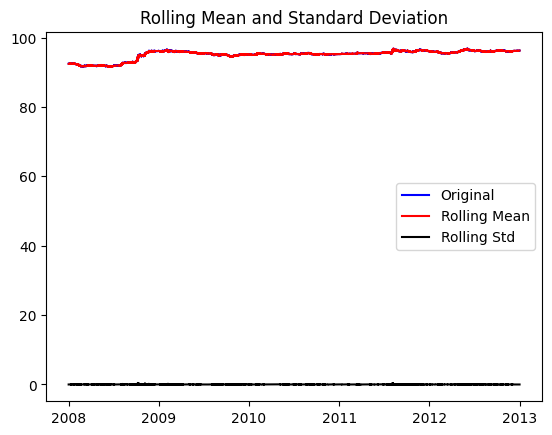

Results of Augmented Dickey-Fuller Test:
Test Statistic                -1.799974e+00
p-value                        3.804748e-01
#Lags Used                     1.270000e+02
Number of Observations Used    1.315313e+06
Critical Value (1%)           -3.430355e+00
Critical Value (5%)           -2.861542e+00
Critical Value (10%)          -2.566771e+00
dtype: float64

Results of Kwiatkowski-Phillips-Schmidt-Shin Test:
Test Statistic           103.799005
p-value                    0.010000
Lags Used                629.000000
Critical Value (10%)       0.347000
Critical Value (5%)        0.463000
Critical Value (2.5%)      0.574000
Critical Value (1%)        0.739000
dtype: float64


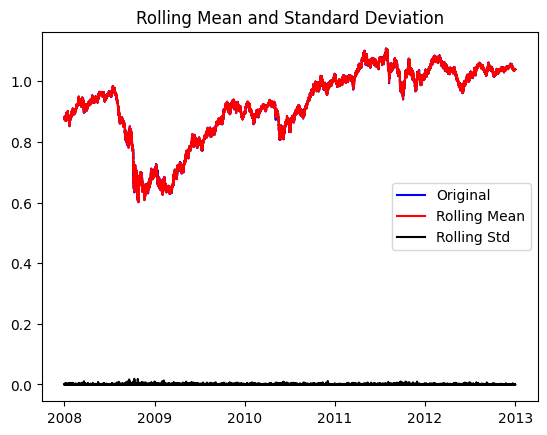

Results of Augmented Dickey-Fuller Test:
Test Statistic                -1.322343e+00
p-value                        6.188892e-01
#Lags Used                     1.290000e+02
Number of Observations Used    1.315311e+06
Critical Value (1%)           -3.430355e+00
Critical Value (5%)           -2.861542e+00
Critical Value (10%)          -2.566771e+00
dtype: float64

Results of Kwiatkowski-Phillips-Schmidt-Shin Test:
Test Statistic           127.45188
p-value                    0.01000
Lags Used                629.00000
Critical Value (10%)       0.34700
Critical Value (5%)        0.46300
Critical Value (2.5%)      0.57400
Critical Value (1%)        0.73900
dtype: float64


In [22]:
# Estimate an AR(2) model and find roots of characteristic equation test for normality. 
#  a low p-value indicates that the null hypothesis can be rejected and the
#  data is not normally distributed.
#  Apply Shapiro-Wilk test
#  Apply Kolmogorov-Smirnov test

from statsmodels.tsa.stattools import adfuller, kpss
# from numba import jit


def plot_rolling_statistics(ts, window=12):
    rolmean = ts.rolling(window=window).mean()
    rolstd = ts.rolling(window=window).std()

    plt.plot(ts, color='blue', label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation')
    plt.show()

# @jit(nopython=True)
def adf_test_fast(ts):
    return adfuller(ts)

# @jit(nopython=True)
def kpss_test_fast(ts):
    return kpss(ts)

def test_stationarity(ts, window=12):
    plot_rolling_statistics(ts, window)

    print('Results of Augmented Dickey-Fuller Test:')
    adf_test_results = adf_test_fast(ts.values)
    adf_output = pd.Series(adf_test_results[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for key, value in adf_test_results[4].items():
        adf_output['Critical Value (%s)' % key] = value
    print(adf_output)

    print('\nResults of Kwiatkowski-Phillips-Schmidt-Shin Test:')
    kpss_test_results = kpss_test_fast(ts.values)
    kpss_output = pd.Series(kpss_test_results[0:3], index=['Test Statistic', 'p-value', 'Lags Used'])
    for key, value in kpss_test_results[3].items():
        kpss_output['Critical Value (%s)' % key] = value
    print(kpss_output)

test_stationarity(fil_ts1)
test_stationarity(fil_ts2)

Returns distribution
Descriptive Statistics: Calculate basic summary statistics such as mean, median, standard deviation, skewness, and kurtosis. Other useful measures include the maximum and minimum values, the range of the data, and the coefficient of variation (CV).



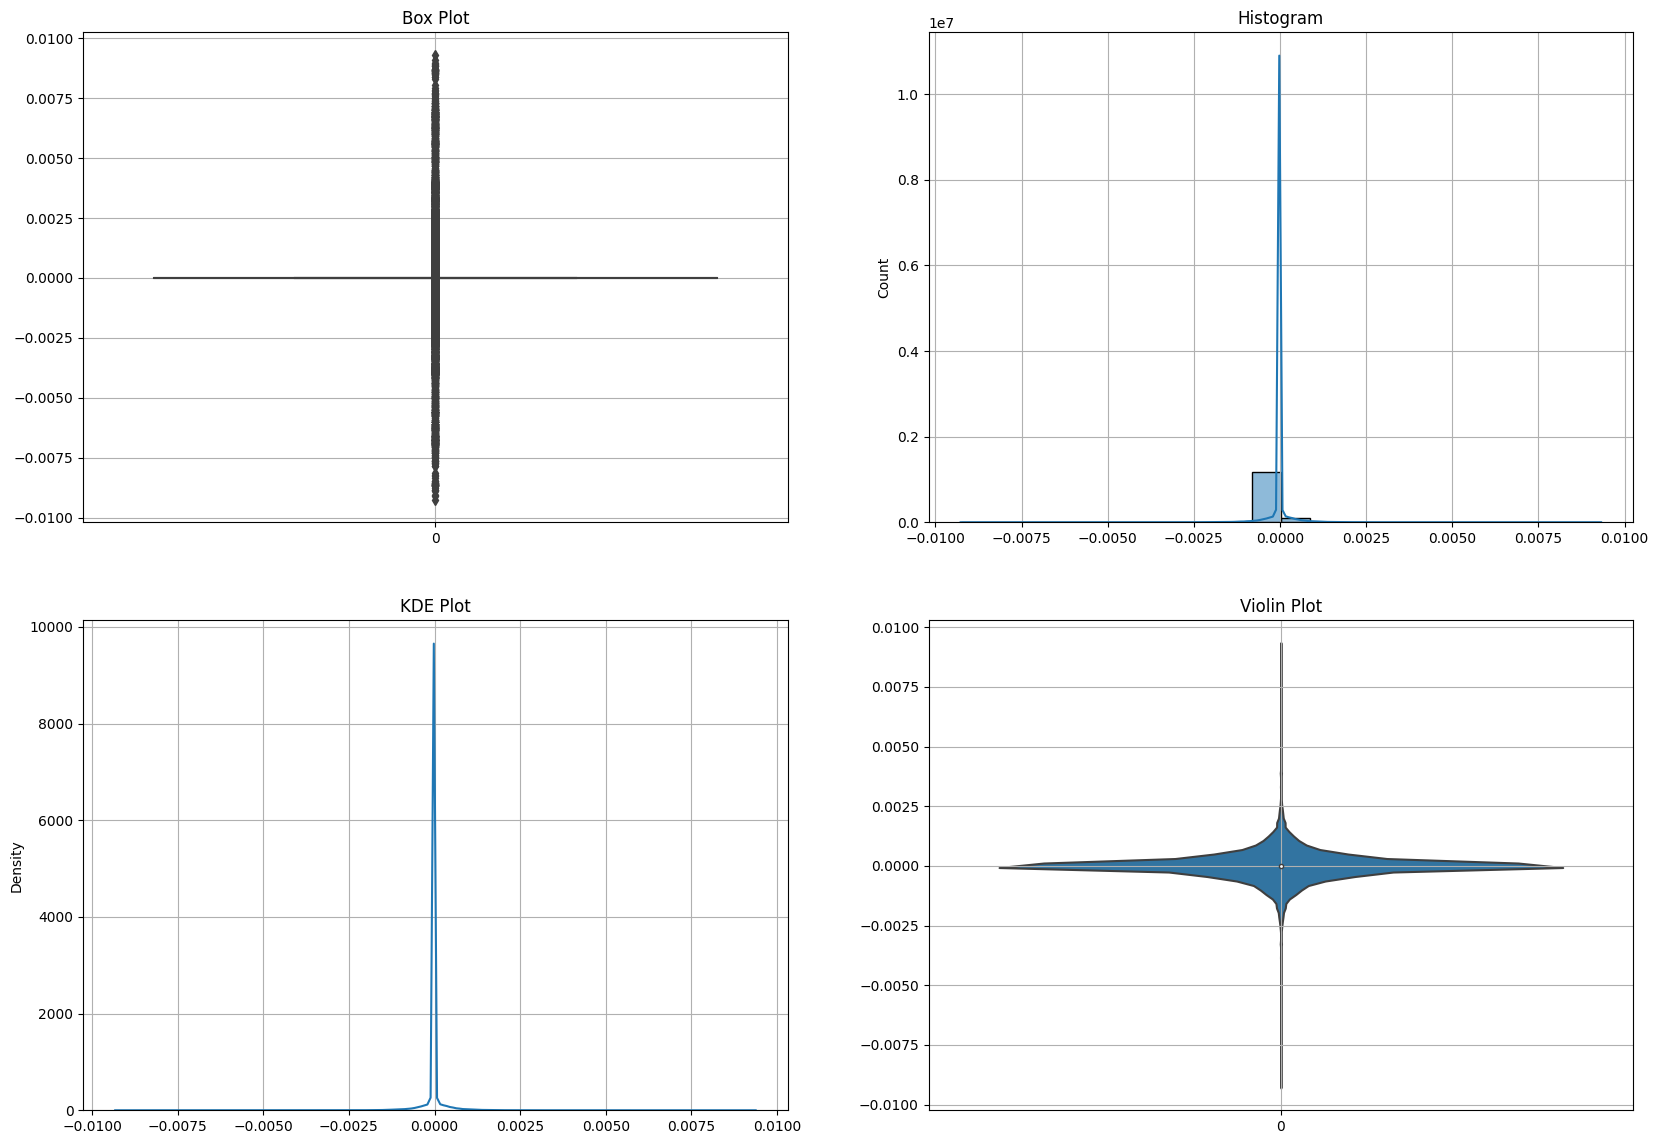

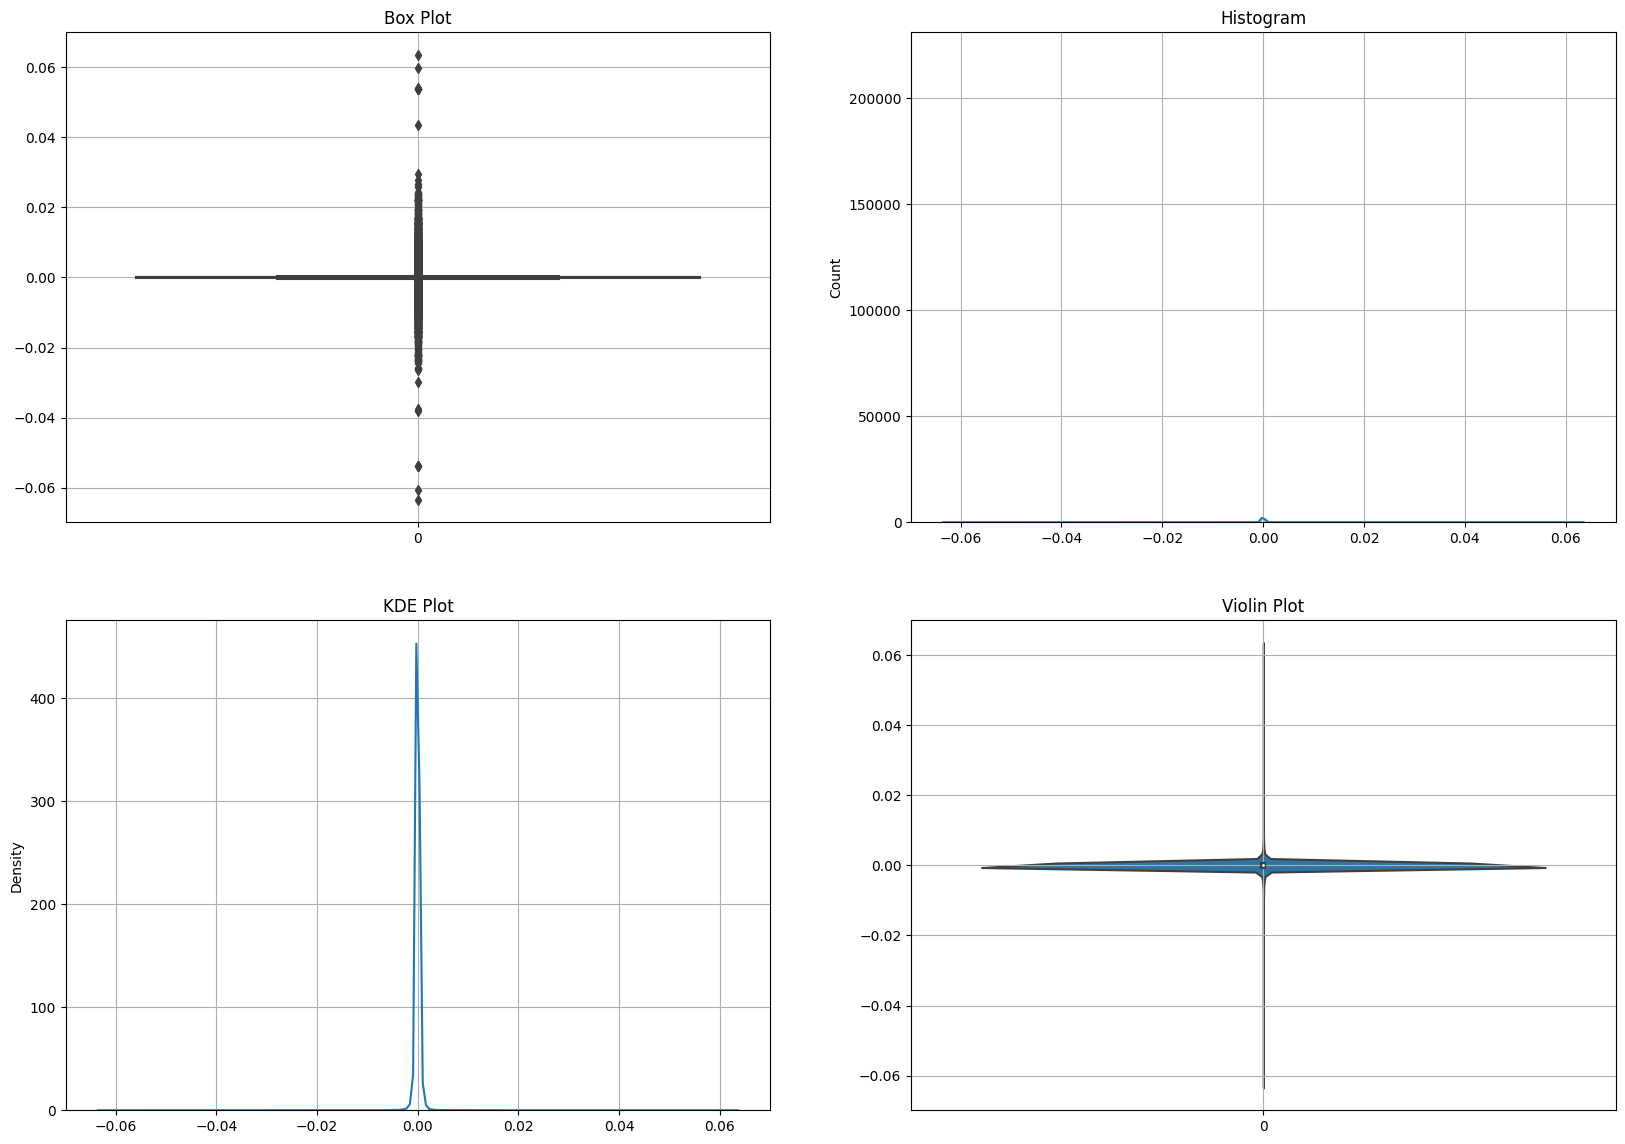

In [28]:
# PLot box plot hist and kde
# use returns 
rt = np.log(clean_df/clean_df.shift(1))
rt.describe()
rt_1 = rt['ts1']
rt_2 = rt['ts2']

def plot_box_hist_kde(data):
    fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(20, 14))

    # Box plot
    sns.boxplot(data=data, ax=axs[0, 0])
    axs[0, 0].set_xlabel('')
    axs[0, 0].set_title('Box Plot')
    axs[0, 0].grid()

    # Histogram
    sns.histplot(data=data, kde=True, ax=axs[0, 1])
    axs[0, 1].set_xlabel('')
    axs[0, 1].set_title('Histogram')
    axs[0, 1].grid()

    # KDE plot
    sns.kdeplot(data=data, ax=axs[1, 0])
    axs[1, 0].set_xlabel('')
    axs[1, 0].set_title('KDE Plot')
    axs[1, 0].grid()

    # Violin plot
    sns.violinplot(data=data, ax=axs[1, 1])
    axs[1, 1].set_xlabel('')
    axs[1, 1].set_title('Violin Plot')
    axs[1, 1].grid()

    plt.show()

# Call the function with the clean_df data
plot_box_hist_kde(rt_1)
plot_box_hist_kde(rt_2)

In [33]:
from statsmodels.stats.diagnostic import acorr_ljungbox

def data_stat(df):
    print("Mean:\n", df.mean())
    print("Variance:\n", df.var())
    print("Covariance:\n", df.cov())

def analyze_shapiro_wilk(df):
    for col in df.columns:
        h, p = stats.shapiro(df[col])
        print(f'Shapiro-Wilk test for {col}: Null hypothesis = {h}, p-value = {p}')

def analyze_kolmogorov_smirnov(df):
    for col in df.columns:
        h, p = stats.kstest(df[col], 'norm')
        print(f'Kolmogorov-Smirnov test for {col}: Null hypothesis = {h}, p-value = {p}')

def analyze_skewness_kurtosis(df):
    for col in df.columns:
        skew = stats.skew(df[col])
        kurt = stats.kurtosis(df[col])
        print(f'Skewness for {col}: {skew}')
        print(f'Kurtosis for {col}: {kurt}')

def analyze_normality(df):
    analyze_shapiro_wilk(df)
    analyze_kolmogorov_smirnov(df)
    analyze_skewness_kurtosis(df)

def portmanteau_test(series, lags=10):
    result = acorr_ljungbox(series, lags=lags)
    return pd.DataFrame({'Lag': range(1, lags + 1), 'Test Statistic': result[0], 'p-value': result[1]})

def white_noise_test(series, lags=10):
    result = portmanteau_test(series, lags)
    white_noise = result['p-value'] > 0.05
    return white_noise.all()    
    
def tukey_test(series, k=1.5):
    q1 = series.quantile(0.25)
    q3 = series.quantile(0.75)
    iqr = q3 - q1

    lower_bound = q1 - k * iqr
    upper_bound = q3 + k * iqr

    outliers = series[(series < lower_bound) | (series > upper_bound)]
    return outliers   
    
def analyze_outliers_and_log_returns(log_returns, k=1.5):
    outliers = tukey_test(log_returns, k)
    return log_returns, outliers    
    
data_stat(rt)
analyze_normality(rt)

# Portmanteau test
result = portmanteau_test(rt['ts1'])
print(result)
result = portmanteau_test(rt['ts2'])
print(result)


# White noise test
is_white_noise = white_noise_test(rt)
print(is_white_noise)

# Outliers detection, log returns calculation, and Tukey test
log_returns, outliers = analyze_outliers_and_log_returns(rt)
print(log_returns)
print(outliers)

Mean:
 ts1    3.076994e-08
ts2    1.311734e-07
dtype: float64
Variance:
 ts1    9.934398e-08
ts2    3.379746e-07
dtype: float64
Covariance:
               ts1           ts2
ts1  9.934398e-08 -9.765387e-10
ts2 -9.765387e-10  3.379746e-07
Shapiro-Wilk test for ts1: Null hypothesis = nan, p-value = 1.0
Shapiro-Wilk test for ts2: Null hypothesis = nan, p-value = 1.0
Kolmogorov-Smirnov test for ts1: Null hypothesis = nan, p-value = nan
Kolmogorov-Smirnov test for ts2: Null hypothesis = nan, p-value = nan
Skewness for ts1: nan
Kurtosis for ts1: nan
Skewness for ts2: nan
Kurtosis for ts2: nan


KeyboardInterrupt: 

Discuss the Need for Performing Correlation Analysis and Testing for Autocorrelation and Partial Autocorrelation: Emphasize the importance of understanding the relationship between variables and testing for autocorrelation and partial autocorrelation to identify potential AR and MA terms for a SARIMA model.


21.	Correlation analysis: In addition to calculating the Pearson correlation coefficient between the stock prices at different time points, it may also be useful to examine the cross-correlation function (CCF) between the stock prices and other variables that may be related, such as the prices of other stocks in the same industry, or macroeconomic indicators like interest rates or GDP growth.
Autocorrelation and partial autocorrelation: In addition to examining the ACF and PACF plots to identify potential AR and MA terms for a SARIMA model, it may also be useful to look at higher-order autocorrelations (e.g. ACF and PACF plots for lags > 12 for monthly data) to identify potential seasonality or longer-term dependencies 


In [53]:
rt

,ts1,ts2
datetime,,
2008-01-01 00:00:45,NaN,NaN
2008-01-01 00:02:45,0.000000e+00,0.0
2008-01-01 00:04:45,0.000000e+00,0.0
2008-01-01 00:06:45,0.000000e+00,0.0
2008-01-01 00:08:45,0.000000e+00,0.0
...,...,...
2012-12-31 23:52:45,2.226343e-07,0.0
2012-12-31 23:54:45,0.000000e+00,0.0
2012-12-31 23:56:45,2.240568e-07,0.0


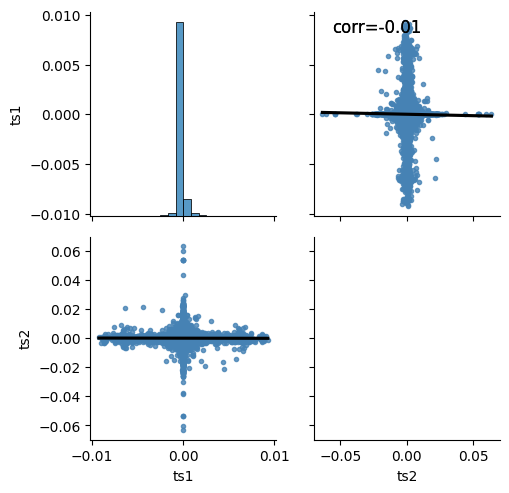

In [51]:
# Compute the Kendall's rank correlation coefficient between all pairs of columns in clean_df
corr = rt.corr(method='kendall').round(2).astype('str')

# Define a function that creates a pair plot and labels the correlation coefficient
# between x and y columns if available
def corr_labels(x=None, y=None, hue=None, corr_dict=None, fontsize=12, **kwargs):
    ax = plt.gca()
    
    # Add the correlation coefficient label if available
    if corr_dict is not None and x.name != y.name:
        ax.annotate(
            f'corr={corr_dict.loc[x.name, y.name]}',
            xy=(0.1, 0.9),
            xycoords=ax.transAxes,
            fontsize=fontsize
        )
    
    return ax

# Create a PairGrid object with clean_df as data
g = sns.PairGrid(data=rt)

# Use histogram plots on the diagonal
g.map_diag(sns.histplot)

# Use the corr_labels function to label the correlation coefficients
# on the off-diagonal plots
g.map_upper(corr_labels, corr_dict=corr)

# Use scatter plots with regression lines on the off-diagonal plots
g.map_lower(
    sns.regplot,
    fit_reg=True,
    ci=None,
    scatter_kws={'color': 'steelblue'},
    marker='.',
    line_kws={'color': 'black'}
)

# Manually create the top right and bottom right plots
n = len(rt.columns)
for i in range(n):
    for j in range(n):
        if i == j:
            continue
        ax = g.axes[i, j]
        if i < j:
            sns.regplot(data=rt, x=rt.columns[j], y=rt.columns[i], ax=ax, fit_reg=True, ci=None, scatter_kws={'color': 'steelblue'}, marker='.', line_kws={'color': 'black'})
            corr_labels(x=rt[rt.columns[j]], y=rt[rt.columns[i]], corr_dict=corr, ax=ax)

# Show the pair plot
plt.show()

In [60]:
def prepare_correlation_df(df, features1, features2, freq, corr_method):
    corr_df = df.resample(rule=freq)[df.columns].corr(method=corr_method)

    df_corr = pd.DataFrame()
    lgnds = set()
    ft2 = set(features2)
    for f1 in features1:
        for f2 in features2:
            if (f'corr({f1}&{f2})' not in lgnds) and (f'corr({f2}&{f1})' not in lgnds) and (f1 != f2):
                df_corr[f'corr({f1}&{f2})'] = corr_df.xs(f1, level=1)[f2]
                lgnds.add(f'[{f1}&{f2}]')
        ft2.discard(f1)
    return df_corr, lgnds

def plot_correlation(df, df_corr, features1, features2, st, ed, lgnds):
    figsize = (30, 15)
    fig = plt.figure(figsize=figsize, tight_layout=True)
    gs = gridspec.GridSpec(3, 5)
    axs = [fig.add_subplot(gs[0, :]), fig.add_subplot(gs[1, :3]), fig.add_subplot(gs[2, :3]), fig.add_subplot(gs[1:, 3:])]

    if len(df_corr.columns) > 0:
        df[list(features1)].plot(ax=axs[0])
        axs[0].margins(x=0)
        axs[0].grid()
        axs[0].axvspan(st, ed, alpha=0.5, color='red')
        axs[0].vlines(x=df_corr.index, ymin=0, ymax=df.max().max(), color='k', alpha=0.3)
        axs[0].set_ylabel('Raw Data')

        df_corr.plot(ax=axs[1], marker='o')
        axs[1].axvline(st, alpha=0.5, color='red', linewidth=10)
        axs[1].legend(loc='lower right')
        axs[1].set_ylabel('Correlation')
        axs[1].grid()

        df_corr.diff().dropna().plot.bar(ax=axs[2])
        axs[2].axhline(y=0, linewidth=1, color='k')
        axs[2].set_xticks([])
        axs[2].legend(loc='lower right')
        axs[2].set_ylabel('Correlation Changing')
        axs[2].grid()

        for f1, f2 in zip(features1, features2):
            axs[3].plot(df[f1].loc[st:ed], df[f2].loc[st:ed], marker='o')

        axs[3].legend(list(lgnds), loc='upper right')
        axs[3].set_xlabel('Sensor 1')
        axs[3].set_ylabel('Sensor 2')
        axs[3].grid()

        plt.show()

            
def freq_corr(features1=None, features2=None, freq=None, corr="pearson", duration=None, st=None, ed=None):
    df = clean_df[clean_df.index <= duration].copy()

    if df.isnull().any().any():
        print('Please, fill the missing values of the dataset!!!')
    else:
        df_corr, lgnds = prepare_correlation_df(df, features1, features2, freq, corr)
        plot_correlation(df, df_corr, features1, features2, st, ed, lgnds)           
            
            
            
dur = (rt.index[-1] - rt.index[0]).days
dr = pd.date_range(start=rt.index[0].strftime('%Y-%m-%d'), periods=dur+1, closed='right')

st_range = pd.date_range(start=dr[0] - pd.Timedelta(days=1), periods=dur)
ed_range = pd.date_range(start=dr[0], periods=dur)

feat1 = widgets.SelectMultiple(description='features I:', options=rt.columns, value=[rt.columns[0]])
feat2 = widgets.SelectMultiple(description='features II:', options=rt.columns, value=[rt.columns[1]])
freq_types = ['1T', '5T', '10T', '30T', '1H', '2H', '3H', '5H', '12H', '1D', '2D', '3D', '5D', '7D']
freq_types_D = ['1 minute', '5 minutes', '10 minutes', '30 minutes', '1 hour', '2 hours', '3 hours', '5 hours', '12 hours', '1 day', '2 days', '3 days', '5 days', '7 days']
freq_drop = widgets.Dropdown(description='Frequency:', options=freq_types, value='1D')

start = widgets.Dropdown(description='Start:', options=st_range)
end = widgets.Dropdown(description='End:', options=ed_range)

corr_method = widgets.Dropdown(description='Corr. Method:', options=['pearson', 'kendall', 'spearman'], value='pearson')

duration = widgets.Dropdown(description='Until:', options=dr[14:], value=dr[-1])
ui = widgets.HBox([feat1, feat2, widgets.VBox([corr_method, duration]), widgets.VBox([freq_drop, start, end])])

out = interactive_output(freq_corr, {'features1': feat1,
                                     'features2': feat2,
                                     'freq': freq_drop,
                                     'st': start,
                                     'ed': end,
                                     'corr': corr_method,
                                     'duration': duration})
display(ui, out)

Output()

In [61]:
def corrPlot(feature=None,st = None,ed = None,freq = None):
    """
    Plots a heatmap of the correlation matrix between the selected sensor(s) in the specified time period,
    with the option to resample the data by frequency.

    Parameters:
    -----------
    feature : str or list of str, default=None
        The name(s) of the sensor(s) to be plotted. If None, the first column of the input DataFrame is used.
    st : str or datetime object, default=None
        The start time of the selected time period. If None, the start of the DataFrame is used.
    ed : str or datetime object, default=None
        The end time of the selected time period. If None, the end of the DataFrame is used.
    freq : str, default=None
        The frequency to resample the data to. Options are '1 minute', '1 hour', and '1 day'. If None, the
        original data is used.

    Returns:
    --------
    None.
    """
    res_df = resampled_df.loc[st:ed].iloc[:-1].copy()
    
    if feature is None:
        feature = [rt.columns[0]]
    elif isinstance(feature, str):
        feature = [feature]
    
    pivot_df = pd.pivot_table(data=res_df, index=res_df.index.time if freq=='1 day' else res_df.index.strftime('%M-%S') if freq=='1 hour' else res_df.index.strftime('%S'), 
                              columns=res_df.index.date if freq=='1 day' else res_df.index.strftime('%Y-%m-%d %H') if freq=='1 hour' else res_df.index.strftime('%Y-%m-%d %H-%M'), 
                              values=feature)

    len_pv = len(pivot_df.columns)
    s = (len_pv // len(feature)) // 2
    ticks_lines = np.arange(len_pv // len(feature), len_pv, len_pv // len(feature))
    ticks_ax = np.arange(s, len_pv, len_pv // len(feature))

    plt.figure(figsize=(12 * len(feature), 12 * len(feature)))
    sns.heatmap(pivot_df.corr().values, annot=True, fmt='.1f', annot_kws={"size": 120 // (s + 1)})

    plt.hlines(ticks_lines, xmin=0, xmax=len_pv, colors='yellow')
    plt.vlines(ticks_lines, ymin=0, ymax=len_pv, colors='yellow')

    plt.xticks(ticks_ax, feature, fontsize=20 + 50 // (s + 1))
    plt.yticks(ticks_ax, feature, fontsize=20 + 50 // (s + 1))

    plt.show()

date_cols = np.unique(rt.index.date)
freq_drop = widgets.Dropdown(description='Frequency:', options=['1 hour',  '1 day'], value='1 day') 

feat = widgets.SelectMultiple(description='Sensor:', options=rt.columns, value = [rt.columns[0]])
start = widgets.Dropdown(description='Start:', options=rt.index) 
end = widgets.Dropdown(description='End:', options=date_cols[1:])

ui = widgets.HBox([feat, widgets.VBox([start, end]), freq_drop])

out = interactive_output(corrPlot, {'feature': feat,
                                     'st': start,
                                     'ed': end,
                                     'freq': freq_drop})
display(ui, out)

NameError: name 'date_cols' is not defined

# 4.Model selection

1.	Cleaned data + outliers removed
    1.	Linear regression
    2.	Exponential smoothing
    3.	ARIMA
    4.	Mean reverting
    5.	Vector auto regression
2.	Log returns of original data and normalised/scaled
    1.	Random forest
    2.	SVM
    3.	Gaussian process
    4.	LightGBM XGBoost
    5.	LSTM


In [64]:
import statsmodels.api as sm
import lightgbm as lgb
from arch import arch_model
from sklearn.ensemble import RandomForestRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import ConstantKernel, RBF
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error
from statsmodels.tsa.api import VAR

In [ ]:
# Split the data into training and testing sets
train_size = int(len(clean_df) * 0.8)
train = clean_df.iloc[:train_size, :]
test = clean_df[train_size:, :]

In [ ]:
def evaluate_predictions(test_y, preds, train_y=None, seasonal_period=None):
    mae = mean_absolute_error(test_y, preds)
    rmse = mean_squared_error(test_y, preds, squared=False)
    mape = np.mean(np.abs((preds - test_y) / test_y)) * 100
    
    if train_y is not None:
        # Compute seasonal period if not provided
        if seasonal_period is None:
            diff = np.abs(train_y[1:] - train_y[:-1])
            seasonal_period = np.argmax(np.bincount(diff))
            
        # Compute RMSSE and MASE
        y_hat_naive = np.roll(train_y, -seasonal_period)[-len(test_y):]
        ss_res = np.sum((test_y - preds)**2)
        ss_naive = np.sum((test_y - y_hat_naive)**2)
        rmsse = np.sqrt(ss_res / ss_naive) if ss_naive > 0 else np.nan
        mase = np.mean(np.abs(test_y - preds)) / np.mean(np.abs(train_y[seasonal_period:] - train_y[:-seasonal_period]))
        return mae, rmse, mape, rmsse, mase
    
    return mae, rmse, mape

def calculate_benchmark_errors(train_y, test_y):
    mean_baseline = train_y.mean()
    last_value_baseline = train_y.iloc[-1]
    rolling_mean_baseline = train_y.rolling(window=30).mean().iloc[-1]
    mae_mean, _, mape_mean = evaluate_predictions(test_y, [mean_baseline] * len(test_y))
    mae_last, _, mape_last = evaluate_predictions(test_y, [last_value_baseline] * len(test_y))
    mae_rolling, _, mape_rolling = evaluate_predictions(test_y, [rolling_mean_baseline] * len(test_y))
    return {
        'Benchmark MAE (mean)': mae_mean,
        'Benchmark MAE (last value)': mae_last,
        'Benchmark MAE (rolling mean)': mae_rolling,
        'Benchmark MAPE (mean)': mape_mean,
        'Benchmark MAPE (last value)': mape_last,
        'Benchmark MAPE (rolling mean)': mape_rolling
    }

def simple_moving_average(series, window_size):
    sma = series.rolling(window=window_size, min_periods=1).mean()
    return sma

def exponential_moving_average(series, alpha):
    ema = series.ewm(alpha=alpha, adjust=False).mean()
    return ema

def fit_simple_exponential_smoothing(train_x, train_y, test_x, test_y):
    model = SimpleExpSmoothing(train_y)
    model_fit = model.fit()
    ses_preds = model_fit.forecast(len(test_y))
    mse, mae, mape = evaluate_predictions(test_y, ses_preds)
    return {'SES MSE': mse, 'SES MAE': mae, 'SES MAPE': mape}
    

def fit_arima(train_x, train_y, test_x, test_y):
    arima = ARIMA(train_y, order=(1, 1, 1)).fit(disp=0)
    arima_preds = arima.forecast(len(test_y))[0]
    mse, mae, mape = evaluate_predictions(test_y, arima_preds)
    return {'ARIMA MSE': mse, 'ARIMA MAE': mae, 'ARIMA MAPE': mape}


def fit_garch(train_x, train_y, test_x, test_y):
    garch = arch_model(train_y, vol='Garch', p=1, o=0, q=1).fit(disp='off')
    garch_preds = garch.forecast(horizon=len(test_y), method='simulation').mean['h.1']
    mse, mae, mape = evaluate_predictions(test_y, garch_preds)
    return {'GARCH MSE': mse, 'GARCH MAE': mae, 'GARCH MAPE': mape}


def fit_var(train_x, train_y, test_x, test_y):
    model = VAR(train_y)
    results = model.fit()
    lag_order = results.k_ar
    preds = results.forecast(train_y.values[-lag_order:], len(test_y))
    mse, mae, mape = evaluate_predictions(test_y, preds)
    return {'VAR MSE': mse, 'VAR MAE': mae, 'VAR MAPE': mape}


In [ ]:

# def linear_regression(train, test):
#     y_train = train
#     x_train = sm.add_constant(np.arange(len(y_train)))
#     model = sm.OLS(y_train, x_train).fit()

#     return model.summary()


# def exponential_smoothing(train, test):
#     y_train = tracemalloc_domain
#     model = sm.tsa.ExponentialSmoothing(y_train, trend='add', seasonal='add', seasonal_periods=12).fit()

#     return model.summary()


# def mean_reverting(train, test):
#     y_train = train
#     y_diff_train = y_train.diff().dropna()
#     model = sm.tsa.ARMA(y_diff_train, order=(0, 1)).fit()

#     return model.summary()



In [66]:
# Split the data into training and testing sets
train_x, test_x, train_y, test_y = train_test_split(X, y, test_size=0.2, random_state=42)

InvalidIndexError: (slice(1052352, None, None), slice(None, None, None))

In [ ]:
def train_random_forest(train_x, train_y, test_x, test_y):
    model = RandomForestRegressor()
    model.fit(train_x, train_y)
    preds = model.predict(test_x)
    mse, mae, mape = evaluate_predictions(test_y, preds)

    print("Random Forest")
    print(f"MSE: {mse:.3f}")
    print(f"MAE: {mae:.3f}")
    print(f"MAPE: {mape:.3f}")
    
    return mse, mae, mape

def train_gaussian_process(train_x, train_y, test_x, test_y):
    # Fit Gaussian Process model
    kernel = ConstantKernel() * RBF()
    model = GaussianProcessRegressor(kernel=kernel)
    model.fit(train_x, train_y)

    # Make predictions
    preds, std = model.predict(test_x, return_std=True)

    # Evaluate predictions
    mse, mae, mape = evaluate_predictions(test_y, preds)

    print("Gaussian Process")
    print(f"MSE: {mse:.3f}")
    print(f"MAE: {mae:.3f}")
    print(f"MAPE: {mape:.3f}")
    
    return mse, mae, mape

def train_lightgbm(train_x, train_y, test_x, test_y):
    # Fit LightGBM model
    params = {'objective': 'regression'}
    d_train = lgb.Dataset(train_x, label=train_y)
    model = lgb.train(params, d_train)
    preds = model.predict(test_x)

    # Evaluate predictions
    mse, mae, mape = evaluate_predictions(test_y, preds)

    print("LightGBM")
    print(f"MSE: {mse:.3f}")
    print(f"MAE: {mae:.3f}")
    print(f"MAPE: {mape:.3f}")
    
    return mse, mae, mape

# Generate random data
from sklearn.datasets import make_regression

X, y = make_regression(n_samples=1000, n_features=10, n_informative=5, noise=0.1, random_state=42)

train_x, test_x, train_y, test_y = train_test_split(X, y, test_size=0.2, random_state=42)

# Train and evaluate models
rf_mse, rf_mae, rf_mape = train_random_forest(train_x, train_y, test_x, test_y)
gp_mse, gp_mae, gp_mape = train_gaussian_process(train_x, train_y, test_x, test_y)
lgb_mse, lgb_mae, lgb_mape = train_lightgbm(train_x, train_y, test_x, test_y)

In [ ]:
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

In [ ]:
def scale_data(train_data, test_data):
    scaler = MinMaxScaler()
    train_scaled = scaler.fit_transform(train_data)
    test_scaled = scaler.transform(test_data)
    return train_scaled, test_scaled


def fit_lstm(train_x, train_y, test_x, test_y, lstm_units=50, look_back=1, num_epochs=10, batch_size=32):
    # Reshape input to be [samples, time steps, features]
    train_x = train_x.reshape((train_x.shape[0], look_back, 1))
    test_x = test_x.reshape((test_x.shape[0], look_back, 1))

    # Build LSTM model
    model = Sequential()
    model.add(LSTM(8, input_shape=(look_back, 1), return_sequences=True))
    model.add(LSTM(4))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mape'])

    # Fit the model
    model.fit(train_x, train_y, epochs=num_epochs, batch_size=batch_size, verbose=2)

    # Make predictions
    train_pred = model.predict(train_x)
    test_pred = model.predict(test_x)

    # Inverse scaling of the predictions
    train_pred = scaler.inverse_transform(train_pred)
    train_y = scaler.inverse_transform(train_y)
    test_pred = scaler.inverse_transform(test_pred)
    test_y = scaler.inverse_transform(test_y)

    # Create a DataFrame of the predictions and actual values
    train_results = pd.DataFrame({'Actual': train_y.flatten(), 'Predicted': train_pred.flatten()}, index=train_data.index[1:])
    test_results = pd.DataFrame({'Actual': test_y.flatten(), 'Predicted': test_pred.flatten()}, index=test_data.index[1:])

    # Evaluate the predictions
    train_mse, train_mae, train_mape = evaluate_predictions(train_y, train_pred)
    test_mse, test_mae, test_mape = evaluate_predictions(test_y, test_pred)

    # Print the evaluation metrics
    print("Train MSE: {:.3f}, Train MAE: {:.3f}, Train MAPE: {:.3f}".format(train_mse, train_mae, train_mape))
    print("Test MSE: {:.3f}, Test MAE: {:.3f}, Test MAPE: {:.3f}".format(test_mse, test_mae, test_mape))

    return pd.concat([train_results, test_results])


def unscale_data(pred, actual):
    scaler = MinMaxScaler()
    scaler.fit(actual)
    pred = scaler.inverse_transform(pred)
    actual = scaler.inverse_transform(actual)
    return pred, actual

Auto ARIMA model

In [ ]:
%matplotlib inline
def corrTable(freq=None, cols=None, corr='pearson', chst=False, model=None, st=None, ed=None, test_size=None):
    corr_df = resampled_df.resample(rule=frequency[freq])[resampled_df.columns].corr(method=corr)
    df_corr = pd.DataFrame()

    lgnds = set()
    ft2 = set(clean_df.columns)

    for f1 in clean_df.columns:
        for f2 in clean_df.columns:
            if (f'corr({f1}&{f2})' not in lgnds) and (f'corr({f2}&{f1})' not in lgnds) and (f1 != f2):
                df_corr[pos_corr[f'corr({f1}&{f2})']] = corr_df.xs(f1, level=1)[f2]
                lgnds.add(f'[{f1}&{f2}]')
        ft2.discard(f1)

    df_corr = df_corr[st:ed]

    if chst:
        for col in df_corr.columns:
            result = adfuller(df_corr[col].dropna())
            print(f'{col}: ADF Statistic: %f' % result[0], end=' |')
            print('p-value: %f' % result[1])
    else:
        print()

    df_corr.dropna(inplace=True)
    global train
    train = df_corr[:int(len(df_corr)*test_size/100)]
    test = df_corr[int(len(df_corr)*test_size/100):]

    axs = train[list(cols)].plot(subplots=True, grid=True, marker='o', legend=False, figsize=(40, len(cols)*5), color='black')
    test[list(cols)].plot(ax=axs, subplots=True, grid=True, marker='o', legend=False, color='b')

    prediction = pd.DataFrame(index=test.index)

    for i, col in enumerate(cols):
        arima_model = auto_arima(train[col], start_p=0, d=1, start_q=0, max_p=5, 
                                max_d=5, max_q=5, start_P=0, D=1, start_Q=0, 
                                max_P=5, max_D=5, max_Q=5, m=7, seasonal=True, 
                                error_action='warn', trace=False, supress_warnings=True,
                                random_state=101, n_fits=50)
        params = arima_model.get_params()
        order = params['order']
        s_order = params['seasonal_order']
        prediction[col] = arima_model.predict(n_periods=len(test))

        axs[i].set_title(f'SARIMAX{order}x{s_order} = [test metrics: r2_score={r2_score(test[col], prediction[col]):.2f} | mse={mean_squared_error(test[col], prediction[col]):.2f} | mae={mean_absolute_error(test[col], prediction[col]):.2f}]')

    prediction.plot(ax=axs, subplots=True, grid=True, marker='o', legend=False, color='r')

    for i, col in enumerate(cols):
        axs[i].set_ylabel(col)
        axs[i].legend(['train', 'test', 'prediction'], loc='upper right')
        axs[i].vlines(x=train.index[-1], ymin=-1, ymax=1)


        

freq_drop = widgets.Dropdown(description='Frequency:', options=freq_types, value='1 hour')   

corr_method = widgets.Dropdown(description='Corr. Method:', options=['pearson', 'kendall', 'spearman'], value='pearson')

corr_columns = widgets.SelectMultiple(description='Columns:', options=corr_cols, value=[corr_cols[0]])

models = widgets.Dropdown(description='Model:', options=['ARIMA'], value='ARIMA')

test_size = widgets.Dropdown(description='Train-size:', options=[40, 50, 60, 70, 75, 80, 85, 90], value=70)

st_test = widgets.Checkbox(value=False,description='Check Stationarity',disabled=False,indent=True)

ui = widgets.HBox([corr_columns, widgets.VBox([start, end]), widgets.VBox([corr_method, freq_drop]),  widgets.VBox([test_size, models]), st_test])

out = interactive_output(corrTable, {'freq': freq_drop,'corr': corr_method,'cols':corr_columns,
                                     'chst': st_test,'model': models,'start': start,'end': end,
                                     'test_size':test_size})

display(ui, out)